 netconvert --node-files project2.nod.xml --edge-files peoject2.edge.xml -t project2.type.xml -o project2.net.xml 

 netconvert --node-files project2.nod.xml --edge-files project2_carfollowing.edge.xml -t project2_carfollowing.type.xml -o project2_carfollowing.net.xml

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import traci
import time
import xml.etree.ElementTree as ET
import pandas as pd
import os
import traci.constants as tc
import sys
from IPython.display import display, Markdown

## 2.1

改车的desired speed这样方便

In [2]:
# define the path of sumo in computer
if 'SUMO_HOME' in os.environ:
	sumo_path=os.environ['SUMO_HOME']
else:
    # edit path
    sumo_path = '/usr/local/Cellar/sumo/1.9.2_2/share/sumo'

sys.path.append(os.path.join(sumo_path, 'tools'))
sys.path.append(os.path.join(sumo_path, 'bin'))

In [29]:
def vehicle2file(file_path,max_speed):
    # Write arrivals to a file (e.g., sumo_test.arr.xml)
    with open(file_path, 'w') as f:
        f.write('<routes>\n')
        f.write(f'<vType id="car" accel="1.0" decel="1.5" sigma="0.5" length="5.0" minGap="2" maxSpeed="{max_speed}" carFollowModel="IDM" delta="4" tau="1"/>\n')
        f.write('<route id="r1" edges="edge1 edge2 edge3 edge4 edge5"/>\n')

        for num_vehicles in range(8):
            # the next arrival time is calculated by the last arrival time plus their interarrival time
            f.write(f'<vehicle depart="0" route="r1" id="vehicle{num_vehicles}" type="car" departPos="{num_vehicles*10}" tau="1"/>\n')
        f.write('</routes>')

In [30]:
file_path='project2_carfollowing_highway.rou.xml'
max_speed_highway=33.33
vehicle2file(file_path,max_speed_highway)
file_path='project2_carfollowing_city.rou.xml'
max_speed_city=15
vehicle2file(file_path,max_speed_city)

In [39]:
def simulate_scenario(sumo_cmd):
    # Connect to SUMO
    traci.start(sumo_cmd)
    try: 
        # Get the list of all vehicle IDs
        vehicle_ids = ['vehicle'+str(i) for i in range(8)]

        # Create dictionaries to store positions and speeds for each vehicle
        distances = {veh_id: [] for veh_id in vehicle_ids}
        speeds = {veh_id: [] for veh_id in vehicle_ids}    

        for _ in range(100):
            traci.simulationStep()
            simulation_time=traci.simulation.getTime()
            veh_id='vehicle7'

            # Control the behavior of the lead vehicle
            if simulation_time <= 20:
              # Accelerate for 20 seconds with an acceleration rate of 0.9 m/s^2            
              traci.vehicle.setSpeed(veh_id, traci.vehicle.getSpeed(veh_id)+0.9*traci.simulation.getDeltaT())
            elif 20 < simulation_time <= 40:
              # Run with constant speed for the next 20 seconds
              traci.vehicle.setSpeed(veh_id, traci.vehicle.getSpeed(veh_id)+0*traci.simulation.getDeltaT())
            elif 40 < simulation_time:
              # decelerate constantly with deceleration rate of 1.5 m/s 2 until it stops.
              traci.vehicle.setSpeed(veh_id, max(0.0, traci.vehicle.getSpeed(veh_id) - 1.5 * traci.simulation.getDeltaT()))        

            # Record positions and speeds for each vehicle
            for veh_id in vehicle_ids:
                distances[veh_id].append(traci.vehicle.getDistance(veh_id))
                speeds[veh_id].append(traci.vehicle.getSpeed(veh_id))

        
        
         # Print simulation result
        print("Simulation completed successfully.")
        
        # Output descriptive statistics for distances
        distances_df = pd.DataFrame(distances)
        distances_stats = distances_df.describe()
        print("Distances Descriptive Statistics:")
        display(Markdown(distances_stats.to_markdown()))

        # Output descriptive statistics for speeds
        speeds_df = pd.DataFrame(speeds)
        speeds_stats = speeds_df.describe()
        print("\nSpeeds Descriptive Statistics:")
        display(Markdown(speeds_stats.to_markdown()))       

        # Plot positions and speeds for each vehicle
        plt.figure(figsize=(12, 6))
        
        # Plot distances
        plt.subplot(2, 1, 1)
        for veh_id in vehicle_ids:
            plt.plot(range(len(distances[veh_id])), distances[veh_id], label=f'{veh_id} Distance')
        plt.title('Vehicle Distances Traveled Over Time')
        plt.xlabel('Time Step')
        plt.ylabel('Distance')
        plt.legend()


        # Plot speeds
        plt.subplot(2, 1, 2)
        for veh_id in vehicle_ids:
            plt.plot(range(len(speeds[veh_id])), speeds[veh_id], label=f'{veh_id} Speed')
        plt.title('Vehicle Speeds Over Time')
        plt.xlabel('Time Step')
        plt.ylabel('Speed')
        plt.legend()

        plt.tight_layout()
        plt.show()

    finally:
        # Close the TraCI connection
        traci.close()

---------------project2_carfollowing_highway.sumo.cfg-------------------
Simulation completed successfully.
Distances Descriptive Statistics:


|       |   vehicle0 |   vehicle1 |   vehicle2 |   vehicle3 |   vehicle4 |   vehicle5 |   vehicle6 |   vehicle7 |
|:------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|
| count |    100     |    100     |    100     |    100     |    100     |    100     |    100     |    100     |
| mean  |    371.902 |    376.988 |    383.275 |    388.747 |    393.685 |    398.84  |    408.728 |    414.469 |
| std   |    236.015 |    233.101 |    229.948 |    226.255 |    222.179 |    217.69  |    212.192 |    205.874 |
| min   |      0     |      0     |      0     |      0     |      0     |      0     |      0     |      0     |
| 25%   |    113.618 |    126.881 |    142.887 |    160.934 |    179.941 |    199.86  |    231.327 |    254.92  |
| 50%   |    488.269 |    506.691 |    529.194 |    544.783 |    554.599 |    560.805 |    567.692 |    565.789 |
| 75%   |    587.359 |    584.332 |    581.326 |    578.298 |    575.263 |    572.246 |    569.243 |    566.084 |
| max   |    587.359 |    584.332 |    581.326 |    578.298 |    575.263 |    572.246 |    569.243 |    566.084 |


Speeds Descriptive Statistics:


|       |   vehicle0 |   vehicle1 |   vehicle2 |   vehicle3 |   vehicle4 |   vehicle5 |   vehicle6 |   vehicle7 |
|:------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|
| count |  100       |  100       |  100       |  100       |  100       |  100       | 100        | 100        |
| mean  |    5.87359 |    5.84332 |    5.81326 |    5.78298 |    5.75263 |    5.72246 |   5.69243  |   5.66084  |
| std   |    6.595   |    6.5931  |    6.64717 |    6.64415 |    6.61264 |    6.58383 |   6.77473  |   6.70644  |
| min   |    0       |    0       |    0       |    0       |    0       |    0       |   0        |   0        |
| 25%   |    0       |    0       |    0       |    0       |    0       |    0       |   0        |   0        |
| 50%   |    2.69895 |    2.58941 |    2.43969 |    2.23489 |    1.95542 |    1.57671 |   0.623589 |   0.295335 |
| 75%   |   13.3256  |   13.3012  |   13.5294  |   13.6285  |   13.4362  |   13.6215  |  13.6632   |  13.8161   |
| max   |   16.2903  |   16.1437  |   16.1651  |   15.9947  |   15.7491  |   15.5685  |  16.1334   |  15.5907   |

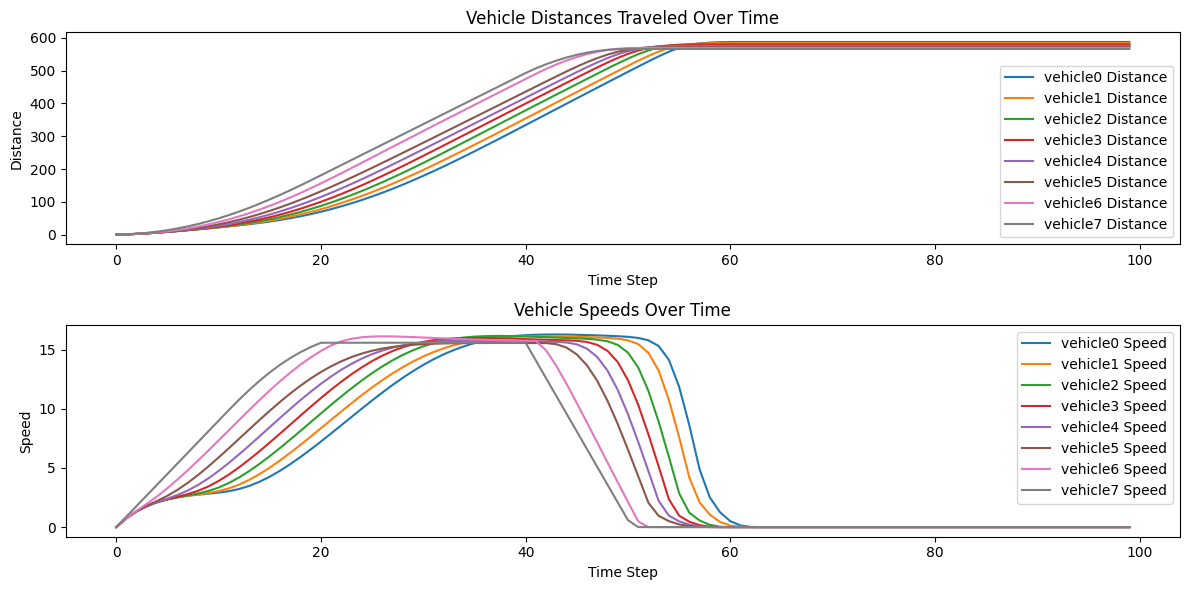

---------------project2_carfollowing_city.sumo.cfg-------------------
Simulation completed successfully.
Distances Descriptive Statistics:


|       |   vehicle0 |   vehicle1 |   vehicle2 |   vehicle3 |   vehicle4 |   vehicle5 |   vehicle6 |   vehicle7 |
|:------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|
| count |    100     |    100     |    100     |    100     |    100     |    100     |    100     |    100     |
| mean  |    339.651 |    345.024 |    350.564 |    356.313 |    362.336 |    368.733 |    375.686 |    383.623 |
| std   |    214.342 |    212.021 |    209.354 |    206.291 |    202.758 |    198.641 |    193.732 |    187.57  |
| min   |      0     |      0     |      0     |      0     |      0     |      0     |      0     |      0     |
| 25%   |    111.456 |    123.677 |    137.668 |    153.477 |    171.247 |    191.318 |    214.425 |    242.133 |
| 50%   |    424.441 |    444.246 |    465.062 |    486.509 |    505.709 |    517.633 |    521.452 |    520.233 |
| 75%   |    541.278 |    538.269 |    535.262 |    532.254 |    529.247 |    526.241 |    523.235 |    520.233 |
| max   |    541.278 |    538.269 |    535.262 |    532.254 |    529.247 |    526.241 |    523.235 |    520.233 |


Speeds Descriptive Statistics:


|       |   vehicle0 |   vehicle1 |   vehicle2 |   vehicle3 |   vehicle4 |   vehicle5 |   vehicle6 |   vehicle7 |
|:------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|
| count |  100       |  100       |  100       |  100       |  100       |  100       | 100        |  100       |
| mean  |    5.41278 |    5.38269 |    5.35262 |    5.32254 |    5.29247 |    5.26241 |   5.23235  |    5.20233 |
| std   |    5.57837 |    5.65711 |    5.74025 |    5.82741 |    5.91728 |    6.00829 |   6.0993   |    6.19059 |
| min   |    0       |    0       |    0       |    0       |    0       |    0       |   0        |    0       |
| 25%   |    0       |    0       |    0       |    0       |    0       |    0       |   0        |    0       |
| 50%   |    2.97261 |    2.82161 |    2.62519 |    2.45988 |    1.95529 |    1.38898 |   0.641829 |    0       |
| 75%   |   12.2548  |   12.3038  |   12.3695  |   12.4589  |   12.5835  |   12.717   |  12.684    |   12.823   |
| max   |   13.4083  |   13.5085  |   13.6197  |   13.7415  |   13.8757  |   14.0246  |  14.1635   |   14.2515  |

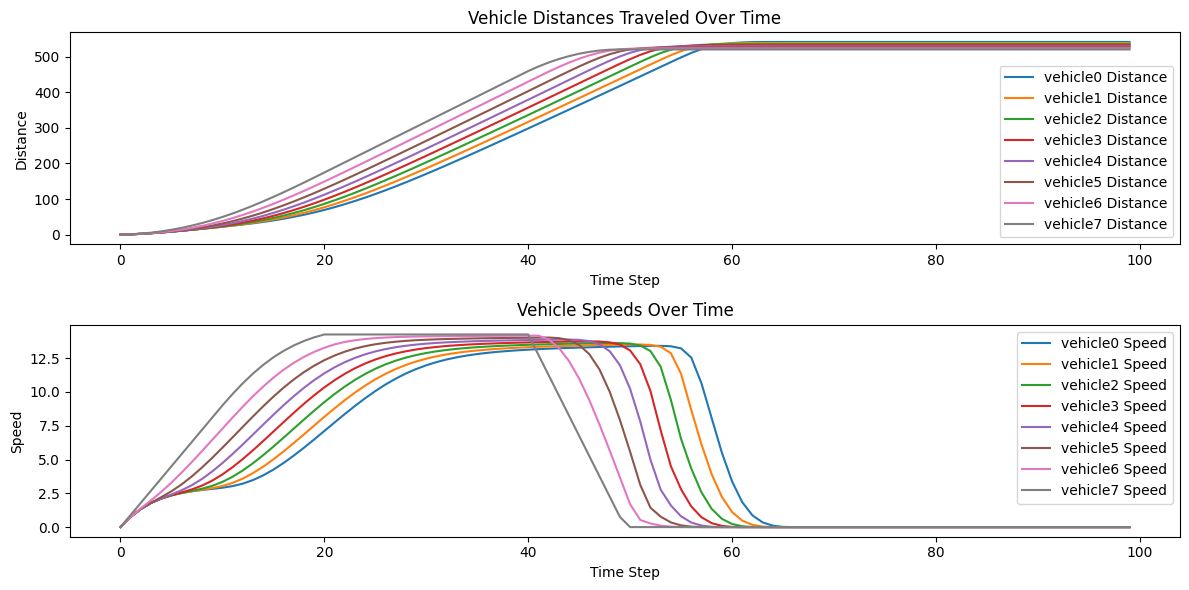

In [41]:
conf_file=['project2_carfollowing_highway.sumo.cfg','project2_carfollowing_city.sumo.cfg']
for f in conf_file:
    print(f'---------------{f}-------------------')
    sumo_cmd=["sumo-gui", "-c", f]
    simulate_scenario(sumo_cmd)

If some parameters of the model are randomized, e.g. ,the safe time gap is
randomized by uniform distribution between 0.8 sec and 1.5 sec, analyze
the car following patterns for both scenarios

In [32]:
import random
# Function to generate a random safe time gap within a specified range
def generate_random_safe_time_gap():
    return random.uniform(0.8, 1.5)

In [33]:
def vehicle2file_3(file_path,max_speed):
    # Write arrivals to a file (e.g., sumo_test.arr.xml)
    with open(file_path, 'w') as f:
        f.write('<routes>\n')
        f.write(f'<vType id="car" accel="1.0" decel="1.5" sigma="0.5" length="5.0" minGap="2" maxSpeed="{max_speed}" carFollowModel="IDM" delta="4" tau="1"/>\n')
        f.write('<route id="r1" edges="edge1 edge2 edge3 edge4 edge5"/>\n')

        for num_vehicles in range(8):
            tau=generate_random_safe_time_gap()
            # the next arrival time is calculated by the last arrival time plus their interarrival time
            f.write(f'<vehicle depart="0" route="r1" id="vehicle{num_vehicles}" type="car" departPos="{num_vehicles*10}" tau="{tau}"/>\n')
        f.write('</routes>')

In [43]:
file_path='project2_carfollowing_highway.rou.xml'
max_speed_highway=33.33
vehicle2file_3(file_path,max_speed_highway)
file_path='project2_carfollowing_city.rou.xml'
max_speed_city=15
vehicle2file_3(file_path,max_speed_city)

---------------project2_carfollowing_highway.sumo.cfg-------------------
Simulation completed successfully.
Distances Descriptive Statistics:


|       |   vehicle0 |   vehicle1 |   vehicle2 |   vehicle3 |   vehicle4 |   vehicle5 |   vehicle6 |   vehicle7 |
|:------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|
| count |    100     |    100     |    100     |    100     |    100     |    100     |    100     |    100     |
| mean  |    371.902 |    376.988 |    383.275 |    388.747 |    393.685 |    398.84  |    408.728 |    414.469 |
| std   |    236.015 |    233.101 |    229.948 |    226.255 |    222.179 |    217.69  |    212.192 |    205.874 |
| min   |      0     |      0     |      0     |      0     |      0     |      0     |      0     |      0     |
| 25%   |    113.618 |    126.881 |    142.887 |    160.934 |    179.941 |    199.86  |    231.327 |    254.92  |
| 50%   |    488.269 |    506.691 |    529.194 |    544.783 |    554.599 |    560.805 |    567.692 |    565.789 |
| 75%   |    587.359 |    584.332 |    581.326 |    578.298 |    575.263 |    572.246 |    569.243 |    566.084 |
| max   |    587.359 |    584.332 |    581.326 |    578.298 |    575.263 |    572.246 |    569.243 |    566.084 |


Speeds Descriptive Statistics:


|       |   vehicle0 |   vehicle1 |   vehicle2 |   vehicle3 |   vehicle4 |   vehicle5 |   vehicle6 |   vehicle7 |
|:------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|
| count |  100       |  100       |  100       |  100       |  100       |  100       | 100        | 100        |
| mean  |    5.87359 |    5.84332 |    5.81326 |    5.78298 |    5.75263 |    5.72246 |   5.69243  |   5.66084  |
| std   |    6.595   |    6.5931  |    6.64717 |    6.64415 |    6.61264 |    6.58383 |   6.77473  |   6.70644  |
| min   |    0       |    0       |    0       |    0       |    0       |    0       |   0        |   0        |
| 25%   |    0       |    0       |    0       |    0       |    0       |    0       |   0        |   0        |
| 50%   |    2.69895 |    2.58941 |    2.43969 |    2.23489 |    1.95542 |    1.57671 |   0.623589 |   0.295335 |
| 75%   |   13.3256  |   13.3012  |   13.5294  |   13.6285  |   13.4362  |   13.6215  |  13.6632   |  13.8161   |
| max   |   16.2903  |   16.1437  |   16.1651  |   15.9947  |   15.7491  |   15.5685  |  16.1334   |  15.5907   |

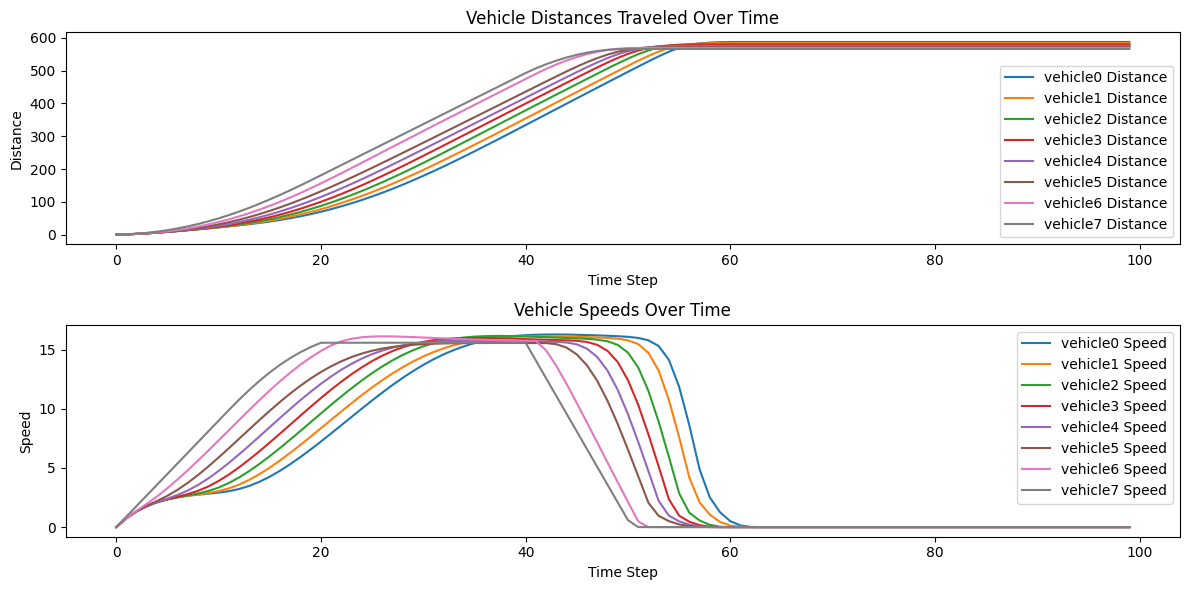

---------------project2_carfollowing_city.sumo.cfg-------------------
Simulation completed successfully.
Distances Descriptive Statistics:


|       |   vehicle0 |   vehicle1 |   vehicle2 |   vehicle3 |   vehicle4 |   vehicle5 |   vehicle6 |   vehicle7 |
|:------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|
| count |    100     |    100     |    100     |    100     |    100     |    100     |    100     |    100     |
| mean  |    339.651 |    345.024 |    350.564 |    356.313 |    362.336 |    368.733 |    375.686 |    383.623 |
| std   |    214.342 |    212.021 |    209.354 |    206.291 |    202.758 |    198.641 |    193.732 |    187.57  |
| min   |      0     |      0     |      0     |      0     |      0     |      0     |      0     |      0     |
| 25%   |    111.456 |    123.677 |    137.668 |    153.477 |    171.247 |    191.318 |    214.425 |    242.133 |
| 50%   |    424.441 |    444.246 |    465.062 |    486.509 |    505.709 |    517.633 |    521.452 |    520.233 |
| 75%   |    541.278 |    538.269 |    535.262 |    532.254 |    529.247 |    526.241 |    523.235 |    520.233 |
| max   |    541.278 |    538.269 |    535.262 |    532.254 |    529.247 |    526.241 |    523.235 |    520.233 |


Speeds Descriptive Statistics:


|       |   vehicle0 |   vehicle1 |   vehicle2 |   vehicle3 |   vehicle4 |   vehicle5 |   vehicle6 |   vehicle7 |
|:------|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|-----------:|
| count |  100       |  100       |  100       |  100       |  100       |  100       | 100        |  100       |
| mean  |    5.41278 |    5.38269 |    5.35262 |    5.32254 |    5.29247 |    5.26241 |   5.23235  |    5.20233 |
| std   |    5.57837 |    5.65711 |    5.74025 |    5.82741 |    5.91728 |    6.00829 |   6.0993   |    6.19059 |
| min   |    0       |    0       |    0       |    0       |    0       |    0       |   0        |    0       |
| 25%   |    0       |    0       |    0       |    0       |    0       |    0       |   0        |    0       |
| 50%   |    2.97261 |    2.82161 |    2.62519 |    2.45988 |    1.95529 |    1.38898 |   0.641829 |    0       |
| 75%   |   12.2548  |   12.3038  |   12.3695  |   12.4589  |   12.5835  |   12.717   |  12.684    |   12.823   |
| max   |   13.4083  |   13.5085  |   13.6197  |   13.7415  |   13.8757  |   14.0246  |  14.1635   |   14.2515  |

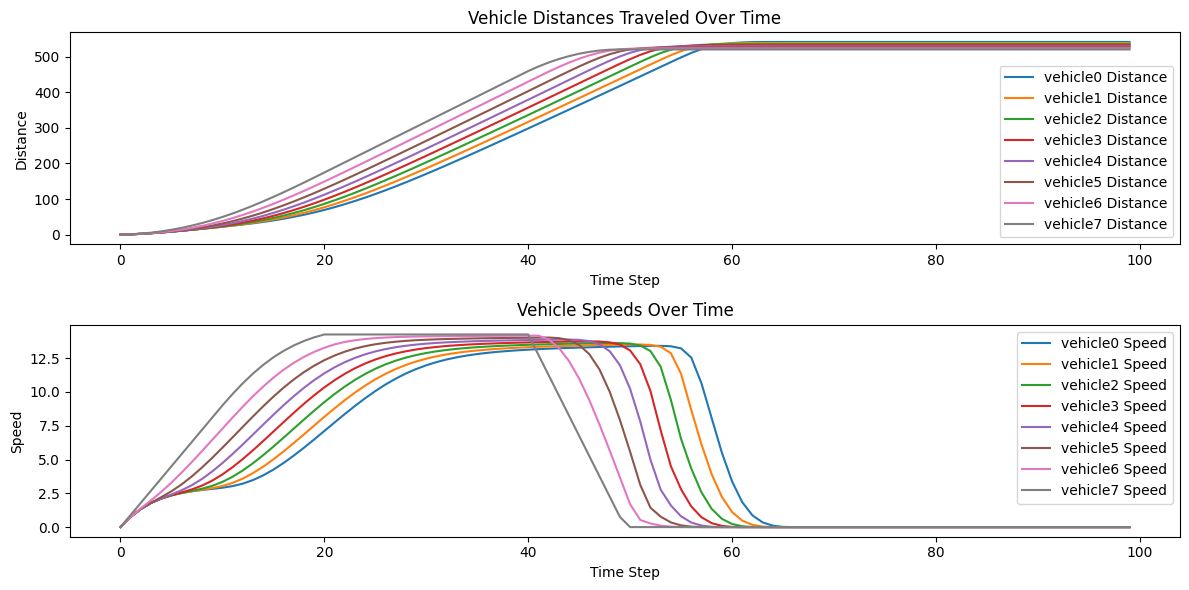

In [46]:
conf_file=['project2_carfollowing_highway.sumo.cfg','project2_carfollowing_city.sumo.cfg']
for f in conf_file:
    print(f'---------------{f}-------------------')
    sumo_cmd=["sumo-gui", "-c", f]
    simulate_scenario(sumo_cmd)

In [45]:
traci.close()

## 2.2

generate random vehicle arrival that follows the poisson process

[1.6200839335442236, 1.0887539358621479, 1.8780549457938593, 0.48447143395289755, 0.11999796069413218, 0.7332303220112866, 0.8273244396696506, 1.6079637533190598, 0.1382621175703659, 0.6865390242839776, 0.8489576001789612, 0.30718455658054516, 1.3684741371033644, 1.4211790456886304, 0.7061026204763515, 0.2504016663146266, 2.192286587052567, 0.039395629376656305, 1.1870120988752308, 0.5060921217135094, 0.3055670669064274, 0.47773905645278403, 1.6700346310275935, 1.5943579388523947, 1.919484399319667, 0.5712615627216333, 0.30879891352457817, 0.8226264448732413, 0.4493368007234083, 0.31230608186533193, 2.58601706829473, 0.5346643875139824, 5.410491001232697, 1.415460512178135, 1.3533209699358664, 2.9136966494242356, 0.4432264645704233, 1.027778501039265, 1.334612044560772, 0.7069942516943587, 2.114052006751438, 2.1928349295804117, 1.074097891369313, 0.13763772112412717, 0.6158676418267205, 0.16971399418596275, 1.2241980291582497, 2.4932752961299984, 0.33299394446648267, 0.0824712631865479

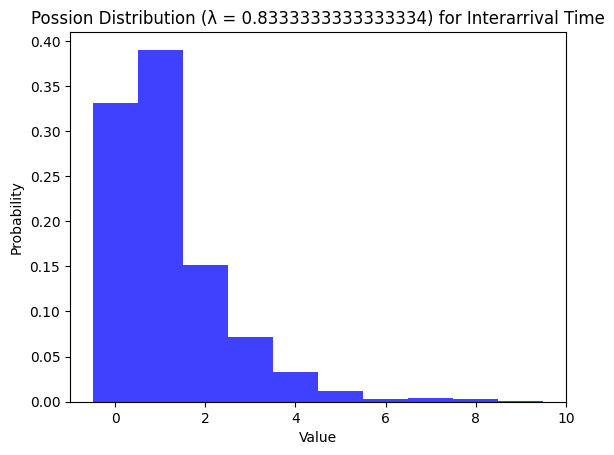

In [2]:
def generate_interarrival_time(lamda):
  start_time=0
  t = start_time

  u1 = np.random.random()
  t -= np.log(u1) / lamda
  
  return t

arrival_rate = 3000/3600  # Arrival rate of 3000 vehicles per hour


# Plot the histogram of multiple generated arrival time random variables
random_variable_size = 3000
interarrival_times = [generate_interarrival_time(arrival_rate) for _ in range(random_variable_size)]

print(interarrival_times)

# Plot the histogram of generated arrival time random variables
plt.hist(interarrival_times, bins=np.arange(min(interarrival_times), max(interarrival_times) + 1) - 0.5, density=True, alpha=0.75, color='b')
plt.title(f'Possion Distribution (λ = {arrival_rate}) for Interarrival Time')
plt.xlabel('Value')
plt.ylabel('Probability')
plt.show()

After generating the vehicles by python, we write them to the xml file called project2.rou.xml.

In [3]:
def vehicle2file(interarrival_times):
    # Write arrivals to a file (e.g., sumo_test.arr.xml)
    with open('project2.rou.xml', 'w') as f:
        f.write('<routes>\n')
        f.write('<vType accel="2.5" decel="5.0" id="Car" length="5.0" maxSpeed="40" sigma="0.0" carFollowModel="IDM"/>\n')
        f.write('<vType accel="1.5" decel="4.0" id="Bus" length="18.0" maxSpeed="25" sigma="0.0" carFollowModel="IDM" />\n')
        f.write('<route id="r1" edges="edge1 edge2 edge3 edge4 edge5"/>\n')

        depart_time=0 
        for num_vehicles,time in enumerate(interarrival_times):
            # the next arrival time is calculated by the last arrival time plus their interarrival time
            depart_time+=time

            vehicle_type = np.random.choice(['Car', 'Bus'], size=1,p=[0.7, 0.3])[0]
            f.write(f'<vehicle depart="{depart_time}" route="r1" id="{num_vehicles}" type="{vehicle_type}"/>\n')
        f.write('</routes>')

In [4]:
# Run the simulation for a certain number of steps
# simulation_steps = 3600  
# warmup_steps = 1000

# Specify the network file based on the scenario you want to run
# network_file = f"project2.net.xml"
# configuration_file=f'project2.sumo.cfg'

# generate the arrival time that follows the poisson process
arrival_rate = 3000/3600  # Arrival rate of 3000 vehicles per hour
random_variable_size = 3000
interarrival_times = [generate_interarrival_time(arrival_rate) for _ in range(random_variable_size)]

# generate the new rou.xml
vehicle2file(interarrival_times)

In project2.add.xml, we put the loop detectors at the beginning and the end of the edge 4 for each lane to measure inflow and outflow per lane. And we let the detecotrs collect the data each 5 minutes.

### task1

The first task is to estimate traffic densities of edge 4 per 5 minutes during
simulated one hour period using traffic flow data from detectors at both
boundaries. Hint: virtual loop detectors can be added in SUMO model
to simulate loop detector data; the density can be estimated continuously
using the conservation law i.e. the variation rate of density of a road section
is compensated by the flow change in a road section i.e. ρk(t + ∆t) =
ρk(t) + 1/∆xk(Q0k − Q1k)∆t.

ρk(t) is the traffic density on lane k at time t  
∆xk is the length of lane k  
Q0k is the inflow (traffic entering) at the begining of lane k  
Q1k is the outflow (traffic leaving) at the end of lane k  
∆t is the time step

After running the simulation by using SUMO, we obtain the detector output files. In our code, we first parse these files into dataframe.

In [2]:
# Parse the XML data
def parse_xml_file(xml_file_path):
    tree = ET.parse(xml_file_path)
    root = tree.getroot()   
    # Placeholder for detector data
    detector_data = []
    # Iterate through intervals
    for interval in root.findall('interval'):
        data = {
            'begin': float(interval.get('begin')),
            'end': float(interval.get('end')),
            'id': interval.get('id'),
            'nVehContrib': int(interval.get('nVehContrib')),
            'flow': float(interval.get('flow')),
            'occupancy': float(interval.get('occupancy')),
            'speed': float(interval.get('speed')),
            'harmonicMeanSpeed': float(interval.get('harmonicMeanSpeed')),
            'length': float(interval.get('length')),
            'nVehEntered': int(interval.get('nVehEntered'))
        }
        detector_data.append(data)

    # Convert to pandas DataFrame
    df = pd.DataFrame(detector_data)
    # Print the DataFrame
    print(df)
    return df

In [3]:
begin_xml_paths=['output_begin_edge4_1.xml','output_begin_edge4_2.xml','output_begin_edge4_3.xml']
end_xml_paths=['output_end_edge4_1.xml','output_end_edge4_2.xml','output_end_edge4_3.xml']

detector_begin_df=[]
detector_end_df=[]

for p in begin_xml_paths:
 detector_begin_df.append(parse_xml_file(p)) 

for p in end_xml_paths:
 detector_end_df.append(parse_xml_file(p)) 

     begin     end                     id  nVehContrib   flow  occupancy  \
0      0.0   300.0  begin_detecor_edge4_0           19  228.0       3.18   
1    300.0   600.0  begin_detecor_edge4_0           42  504.0       8.04   
2    600.0   900.0  begin_detecor_edge4_0           40  480.0       5.61   
3    900.0  1200.0  begin_detecor_edge4_0           39  468.0       5.76   
4   1200.0  1500.0  begin_detecor_edge4_0           39  468.0       7.17   
5   1500.0  1800.0  begin_detecor_edge4_0           36  432.0       6.33   
6   1800.0  2100.0  begin_detecor_edge4_0           38  456.0       4.99   
7   2100.0  2400.0  begin_detecor_edge4_0           38  456.0       7.03   
8   2400.0  2700.0  begin_detecor_edge4_0           39  468.0       6.33   
9   2700.0  3000.0  begin_detecor_edge4_0           37  444.0       6.42   
10  3000.0  3300.0  begin_detecor_edge4_0           39  468.0       6.32   
11  3300.0  3600.0  begin_detecor_edge4_0           41  492.0       6.51   

    speed  

Then we estimate the traffic densities of edge 4 using traffic flow data from detectors at both boundaries.

To estimate traffic densities of edge 4 per 5 minutes during a simulated one-hour period using traffic flow data from detectors at both boundaries, we follow these steps: 

1. Calculate Flow Rates: 
Use the flow data from the detectors (flow column in the DataFrames) to calculate the inflow and outflow rates for each lane and each 5-minute interval. The flow rate represents the number of vehicles passing through a point in a given time period.
  
2. Compute Density Changes:  
Apply the conservation law mentioned in the hint to compute the traffic density changes.   

3. Compute Average Densities:  
Calculate the average density for each 5-minute interval. This can be done by summing up the density changes for all lanes and dividing by the total number of lanes.

4. Visualize Results:  
create plots or tables to visualize the estimated traffic densities over time.

In [49]:
# Step 1: Calculate Flow Rates 
# convert unit from veh/h to veh/s
flow_conversion_factor = 1 / 3600
inflow_rates = [df['flow'].values * flow_conversion_factor for df in detector_begin_df]
outflow_rates = [df['flow'].values * flow_conversion_factor for df in detector_end_df]

In [50]:
# Step 2: Compute Density Changes
delta_t = 300.0  # 5 minutes in seconds
delta_x = 1000  #length of lanes

# density_changes is a list of density changes for each time period
density_changes = [(inflow - outflow) / delta_x * delta_t for inflow, outflow in zip(inflow_rates, outflow_rates)]

# density_changes is a list of lists where each inner list represents the density change for a lane for each time period
cumulative_densities = [[0] for _ in range(len(density_changes))]  # Initial density is zero for each lane
for density_change_for_lane in zip(*density_changes):
    for lane_index, density_change in enumerate(density_change_for_lane):
        # Calculate the cumulative density for the next time step for each lane
        next_density = cumulative_densities[lane_index][-1] + density_change
        cumulative_densities[lane_index].append(next_density)

# Now, cumulative_densities contains the cumulative densities for each lane at each time step

In [51]:
# Step 3: Compute Average Densities
average_densities = [sum(cumulative_densities) / len(cumulative_densities) for cumulative_densities in zip(*cumulative_densities)]

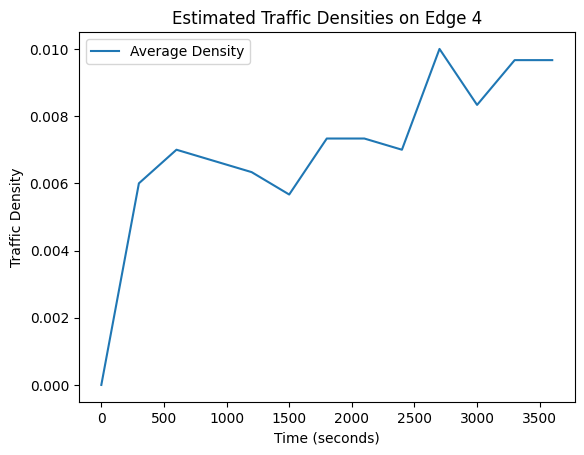

In [52]:
# Step 4: Visualize Results
time_intervals = np.append(detector_begin_df[0]['begin'].values,3600.00)
plt.plot(time_intervals, average_densities, label='Average Density')
plt.xlabel('Time (seconds)')
plt.ylabel('Traffic Density')
plt.title('Estimated Traffic Densities on Edge 4')
plt.legend()
plt.show()

### task2
Compare the time mean speed with the harmonic mean speed at the entry
of edge 4 using simulated data of half an hour (after simulation warmup).
How are they different from the space mean speed of edge 4 that you can
obtained from vehicle trajectories?

Time mean speed: average speed of all vehicles passing a point over a specified time period.   
Space mean speed: average speed of all vehicles occupying a given section of roadway over a specific time period

According to the SUMO documentation, in the decteded data we collect, 'speed' represents the arithmetic mean of the velocities of all completely collected vehicles (-1 indicates that no vehicles were collected). This gives the time mean speed; 'harmonicMeanSpeed' represents the harmonic mean of the velocities of all completely collected vehicles (-1 indicates that no vehicles were collected). This gives the space mean speed.

In [4]:
detector_begin_df

[     begin     end                     id  nVehContrib   flow  occupancy  \
 0      0.0   300.0  begin_detecor_edge4_0           19  228.0       3.18   
 1    300.0   600.0  begin_detecor_edge4_0           42  504.0       8.04   
 2    600.0   900.0  begin_detecor_edge4_0           40  480.0       5.61   
 3    900.0  1200.0  begin_detecor_edge4_0           39  468.0       5.76   
 4   1200.0  1500.0  begin_detecor_edge4_0           39  468.0       7.17   
 5   1500.0  1800.0  begin_detecor_edge4_0           36  432.0       6.33   
 6   1800.0  2100.0  begin_detecor_edge4_0           38  456.0       4.99   
 7   2100.0  2400.0  begin_detecor_edge4_0           38  456.0       7.03   
 8   2400.0  2700.0  begin_detecor_edge4_0           39  468.0       6.33   
 9   2700.0  3000.0  begin_detecor_edge4_0           37  444.0       6.42   
 10  3000.0  3300.0  begin_detecor_edge4_0           39  468.0       6.32   
 11  3300.0  3600.0  begin_detecor_edge4_0           41  492.0       6.51   

In [14]:
# Calculate space mean speed from intervals
total_distance = 1000  # the length of edge 4 is 1000 meters
interval_time = 300  # Simulation time in seconds

# value for each lane
time_mean_speeds = [df['speed'].values for df in detector_begin_df]
harmonic_mean_speeds = [df['harmonicMeanSpeed'].values for df in detector_begin_df]
num_veh_contrib = [df['nVehContrib'].values for df in detector_begin_df]

# value for the whole edge
time_mean_speeds_all_lanes = np.sum(np.array(time_mean_speeds) * np.array(num_veh_contrib), axis=0)
harmonic_mean_speeds_all_lanes = np.sum(np.array(harmonic_mean_speeds) * np.array(num_veh_contrib), axis=0)
total_num_veh_contrib = np.sum(np.array(num_veh_contrib), axis=0)

# Calculate space mean speeds for each time step
space_mean_speeds_all_lanes = time_mean_speeds_all_lanes / total_num_veh_contrib

In [15]:
space_mean_speeds_all_lanes

array([19.12853659, 18.56975309, 19.22802326, 19.28310345, 18.99475   ,
       19.41795181, 19.10272727, 19.15341463, 18.76701149, 18.95789474,
       19.00872093, 18.61436782])

### task3

Explore by simulation the speed-density relation Ve(ρ) (an equilibrum function between traffic speed and density) of edge 4 using speed and density
measured from the loop detectors of the edge. Fit the density and speed
data with an analytical model. (Hint: to sample sufficient data to model the
fudimental diagram, you might need to variate the upstream demand and
reduce downstream supply, e.g. closing one or two lanes of edge 5, in order
to simulate traffic flow of higher densities.)
